SURP Assignment 

This notebook contains the entire Machine Learning workflow to predict log solubility from the smiles data along with some other parameters

The steps are:
1) Loading the data from the csv file - "delaney-processed"
2) Converting smiles into morgan fingerprints
3) Doing an exploratory data analysis (EDA) for better understanding of data
4) Building Baseline Models (Linear regressor, Ridge, Lasso, RandomForest, XGBoost)
5) Performance evaluation and comparison
6) Build a GNN model
   a) Convert smiles to graphs
   b) training the model aand computing the loss

I have the data in a excel file name delaney-processed. It contains SMILES (Simplified Molecular Input Line Entry System) representation of certain molecules which is a way to represent a molecule as a string of characters, encoding its atomic structure in a linear format.



In [4]:
import pandas as pd

# Load the dataset
df = pd.read_csv(r"C:\Users\Mihir\Downloads\SURP\delaney-processed.csv")
print (df.head())

  Compound ID  ESOL predicted log solubility in mols per litre  \
0   Amigdalin                                           -0.974   
1    Fenfuram                                           -2.885   
2      citral                                           -2.579   
3      Picene                                           -6.618   
4   Thiophene                                           -2.232   

   Minimum Degree  Molecular Weight  Number of H-Bond Donors  Number of Rings  \
0               1           457.432                        7                3   
1               1           201.225                        1                2   
2               1           152.237                        0                0   
3               2           278.354                        0                5   
4               2            84.143                        0                1   

   Number of Rotatable Bonds  Polar Surface Area  \
0                          7              202.32   
1           

This data is not ML friendly, thus we need to convert the SMILES data into high dimensional binary vector (Morgan Fingerprints) using rdkit

In [5]:
from rdkit import Chem
from rdkit.Chem.rdFingerprintGenerator import GetMorganGenerator
import numpy as np
from rdkit import DataStructs

gen = GetMorganGenerator(radius=2, fpSize=1024, includeChirality=True)

def smiles_to_morgan(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(1024, dtype=int)
    fp = gen.GetFingerprint(mol)
    arr = np.zeros((1024,), dtype=int)
    DataStructs.ConvertToNumpyArray(fp, arr)
    return arr

#Apply morgan fingerprinting
fps = df['smiles'].apply(smiles_to_morgan)

# Convert bit vector to numpy array
fp_df = pd.DataFrame(fps.tolist(), columns=[f'fp_{i}' for i in range(1024)])
df_combined = pd.concat([df.reset_index(drop=True), fp_df], axis=1)

print(df_combined.shape)
print(df_combined.head())


(1128, 1034)
  Compound ID  ESOL predicted log solubility in mols per litre  \
0   Amigdalin                                           -0.974   
1    Fenfuram                                           -2.885   
2      citral                                           -2.579   
3      Picene                                           -6.618   
4   Thiophene                                           -2.232   

   Minimum Degree  Molecular Weight  Number of H-Bond Donors  Number of Rings  \
0               1           457.432                        7                3   
1               1           201.225                        1                2   
2               1           152.237                        0                0   
3               2           278.354                        0                5   
4               2            84.143                        0                1   

   Number of Rotatable Bonds  Polar Surface Area  \
0                          7              202.32   

We have successfully converted the data from smiles format to morgan fingerprints. Each molecule is associated to a 1024 bit vector. All the 1024 column vectors will be a feature for our Machine Learning Model.

We will do EDA to get a better understanding of our data.

Compound ID                                        0
ESOL predicted log solubility in mols per litre    0
Minimum Degree                                     0
Molecular Weight                                   0
Number of H-Bond Donors                            0
Number of Rings                                    0
Number of Rotatable Bonds                          0
Polar Surface Area                                 0
measured log solubility in mols per litre          0
smiles                                             0
dtype: int64
       ESOL predicted log solubility in mols per litre  Minimum Degree  \
count                                      1128.000000     1128.000000   
mean                                         -2.988192        1.058511   
std                                           1.683220        0.238560   
min                                          -9.702000        0.000000   
25%                                          -3.948250        1.000000   
50%          

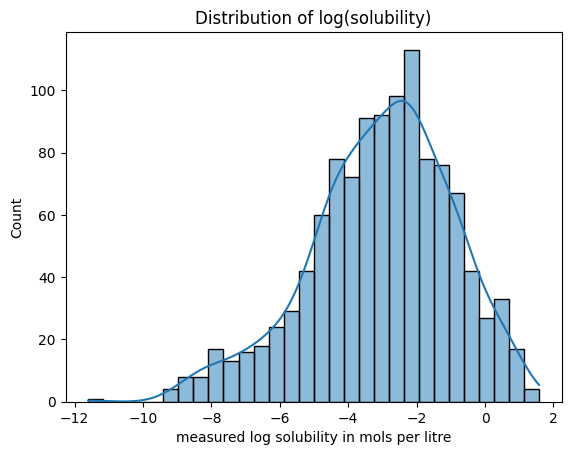

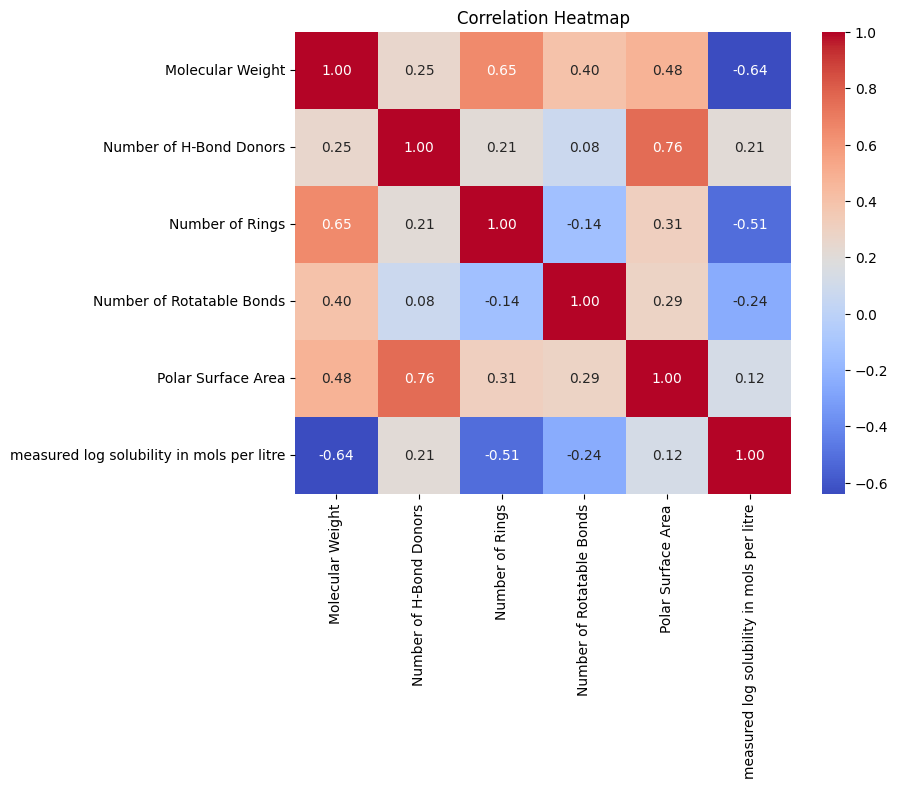

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Checking for any null values
print(df.isnull().sum())

# statistics of the data
print (df.describe())

# Histogram of log solubility
sns.histplot(df['measured log solubility in mols per litre'], bins=30, kde=True)
plt.title("Distribution of log(solubility)")
plt.show()

# Creating a correlation matrix 
correlation_cols = [
    "Molecular Weight",
    "Number of H-Bond Donors",
    "Number of Rings",
    "Number of Rotatable Bonds",
    "Polar Surface Area",
    "measured log solubility in mols per litre"
]

corr_matrix = df[correlation_cols].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()



The data is healthy as there are no missing values.

The log solubility is slightly left skewed with some outliers. This may affect some models and evaluation metrics but we are okay to proceed with this data

The correlation heatmap suggests that there not much correlation between the features and we might not be able to drop some of the features.

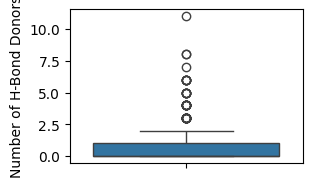

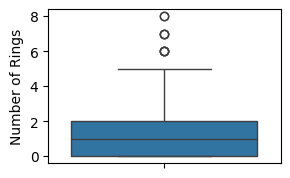

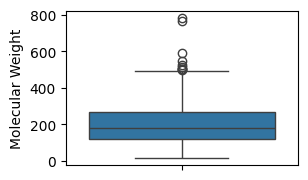

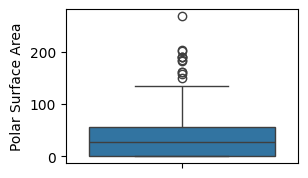

In [7]:
# Boxplot to check the distribution of the data
for col in ["Number of H-Bond Donors", "Number of Rings", "Molecular Weight", "Polar Surface Area"]:
    plt.figure(figsize=(3, 2))
    sns.boxplot(y = df[col])
    plt.title = (f"boxplot of {col}")
    plt.show()

As we can see from the boxplot, there are some outliers and the data is not much skewed.

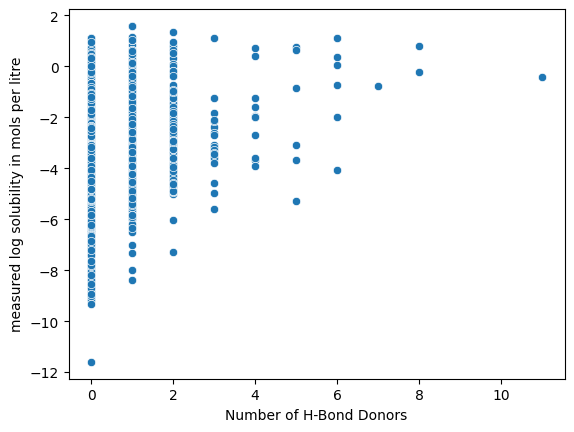

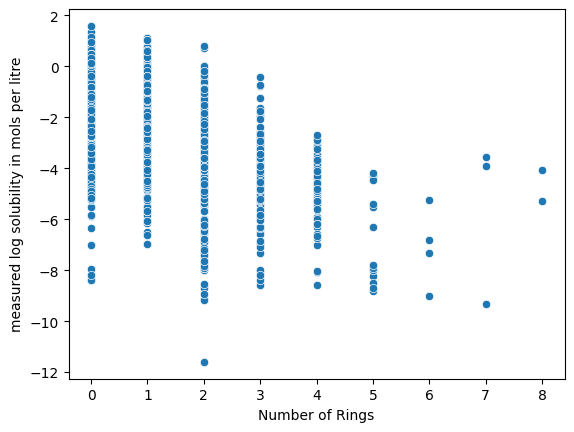

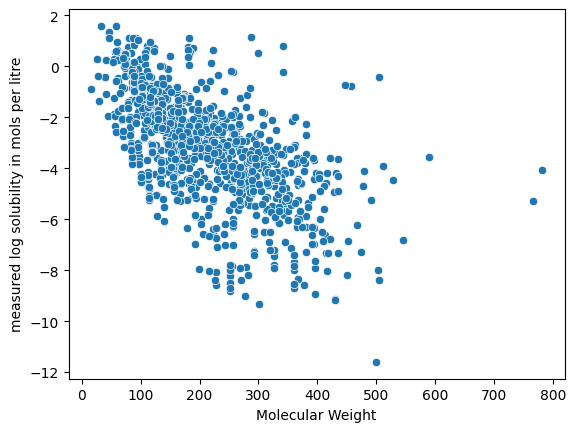

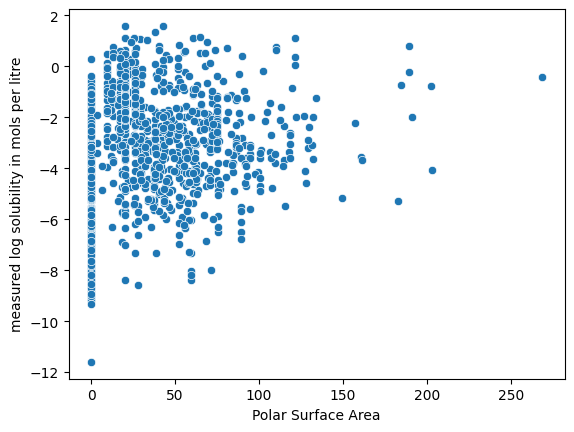

In [8]:
# Scatter plots to visualize any patterns in the data
for col in ["Number of H-Bond Donors", "Number of Rings", "Molecular Weight", "Polar Surface Area"]:
    sns.scatterplot(x=df[col], y=df['measured log solubility in mols per litre'])
    plt.show()

In [9]:
cols = ["Number of H-Bond Donors", "Number of Rings", "Molecular Weight", "Polar Surface Area"]
variance = df_combined[cols].var()

print(variance)


Number of H-Bond Donors        1.187505
Number of Rings                1.737877
Molecular Weight           10555.112508
Polar Surface Area          1251.998629
dtype: float64


Here we can see that the variance in number of h-bond donors and number of rings is very less, thus we may ignore them as features in our model.

We now have finished the EDA and now we will start building the baseline model.

In [10]:
from sklearn.model_selection import train_test_split

X = df_combined.drop(columns = ['measured log solubility in mols per litre', 'smiles', 'Compound ID', 'ESOL predicted log solubility in mols per litre'])
y = df_combined['measured log solubility in mols per litre']

# train-test split of 75-25
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=42)

In [11]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np

def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    MAE = mean_absolute_error(y_test, y_pred)
    RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
    R2 = r2_score(y_test, y_pred)

    return [MAE, RMSE, R2]

In [12]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

models = {
    "Linear Regression": LinearRegression(),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42), 
    "XGBoost": XGBRegressor()
}

results = []

for name, models in models.items():
    metrics = evaluate_model(models, X_train, X_test, y_train, y_test)
    results.append([name] + metrics)
    
columns = ["models", "MAE", "RMSE", "R2"]
df_results = pd.DataFrame(results, columns=columns)

print (df_results)
    

              models       MAE      RMSE        R2
0  Linear Regression  1.985004  2.992642 -0.917404
1              Ridge  0.748286  1.006575  0.783082
2              Lasso  0.735059  0.976990  0.795645
3      Random Forest  0.514604  0.756654  0.877426
4            XGBoost  0.512439  0.713643  0.890965


As seen from the results,
1) Clearly Linear Regressor does not perform well, with the highest MAE, RMSE and a negative R2.
2) Ridge and Lasso did perform well with a lower MAE, RMSE and R2 score close to 0.8 which is fairly acceptable.
3) RandomForest which is a tree based model performs very good with lower MAE, RMSE and a R2 score of 0.877. It is non linear and handles mixed features well and thus it performed better that the linear models.
4) XGBoost performed the best with even lower MAE = 0.51, RMSE = 0.71 and R2 = 0.89. It is also a tree based model slightly complex than RandomForest and thus was able to capture complex relations.

Now we are done creating the baseline models and now we will move on to create GNN (Graph Nueral Network) using deepChem.

As GNN's are graph based nueral network, we need to convert the smiles to molecular graph

There is a compatibility issues using deepchem to build GNN models using the provided data.

So We will use torch for GNN models


In [13]:
from rdkit import Chem
from torch_geometric.data import Data
import torch

def get_atom_features(atom):
    return [
    atom.GetAtomicNum(),
    atom.GetDegree(),
    atom.GetFormalCharge(),
    int(atom.GetHybridization()),
    int(atom.GetIsAromatic()),
    atom.GetTotalNumHs(),
]

def mol_to_graph(smiles, logS):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    atom_feats = [get_atom_features(atom) for atom in mol.GetAtoms()]
    edge_index = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index += [[i, j], [j, i]]  # bidirectional

    x = torch.tensor(atom_feats, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    y = torch.tensor([logS], dtype=torch.float)

    return Data(x=x, edge_index=edge_index, y=y)


In [14]:
import pandas as pd
from torch_geometric.loader import DataLoader

# Convert SMILES to PyG Data objects
graph_list = []
for i, row in df.iterrows():
    graph = mol_to_graph(row['smiles'], row['measured log solubility in mols per litre'])
    if graph is not None:
        graph_list.append(graph)

# Train/Test split (75/25)
split = int(0.75 * len(graph_list))
train_graphs = graph_list[:split]
test_graphs = graph_list[split:]

train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32)


In [15]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool

class GCN(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=128):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)

        self.dropout = nn.Dropout(p=0.25)

        self.fc1 = nn.Linear(hidden_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)

        x = F.relu(self.fc1(x))
        return self.fc2(x).squeeze()


In [16]:
from torch.optim import Adam
from torch_geometric.loader import DataLoader

model = GCN()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

optimizer = Adam(model.parameters(), lr=0.005)
criterion = nn.MSELoss()

for epoch in range(1, 251):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}, Loss: {total_loss / len(train_loader):.4f}")


Epoch 010, Loss: 2.9922
Epoch 020, Loss: 2.7664
Epoch 030, Loss: 1.8716
Epoch 040, Loss: 2.0213
Epoch 050, Loss: 1.6542
Epoch 060, Loss: 1.3984
Epoch 070, Loss: 1.4609
Epoch 080, Loss: 1.4273
Epoch 090, Loss: 1.2382
Epoch 100, Loss: 1.1822
Epoch 110, Loss: 1.2202
Epoch 120, Loss: 1.1703
Epoch 130, Loss: 1.1348
Epoch 140, Loss: 1.0008
Epoch 150, Loss: 1.2315
Epoch 160, Loss: 1.0356
Epoch 170, Loss: 1.0046
Epoch 180, Loss: 0.9799
Epoch 190, Loss: 1.0495
Epoch 200, Loss: 0.8745
Epoch 210, Loss: 0.8526
Epoch 220, Loss: 0.9019
Epoch 230, Loss: 0.8132
Epoch 240, Loss: 0.8253
Epoch 250, Loss: 0.8530


In [40]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

model.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch)
        y_true.extend(batch.y.tolist())
        y_pred.extend(out.tolist())

MAE_GNN = mean_absolute_error(y_true, y_pred)
RMSE_GNN = np.sqrt(mean_squared_error(y_true, y_pred))
R2_GNN = r2_score(y_true, y_pred)

print(f"MAE: {MAE_GNN:.3f}, RMSE: {RMSE_GNN:.3f}, R²: {R2_GNN:.3f}")


MAE: 0.504, RMSE: 0.695, R²: 0.889


So now we have completed creating the GNN. 
As GNN take into account only the local structure and environment whereas the classical models have more general features like molecular weight, number of h-bond donors, etc.

But the log solubility is based on both the factors so developing a hybrid model should be the best.

In [18]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, global_mean_pool
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from rdkit import Chem


def get_atom_features(atom):
    return [
        atom.GetAtomicNum(),
        atom.GetDegree(),
        atom.GetFormalCharge(),
        int(atom.GetHybridization()),
        int(atom.GetIsAromatic()),
        atom.GetTotalNumHs()
    ]


global_features_cols = ["Molecular Weight", "Number of H-Bond Donors", "Number of Rings", "Number of Rotatable Bonds", "Polar Surface Area",]
scaler = StandardScaler()
global_features = scaler.fit_transform(df[global_features_cols])

class HybridGCN(nn.Module):
    def __init__(self, atom_feat_dim=6, global_feat_dim=5, hidden_dim=128):
        super(HybridGCN, self).__init__()
        self.conv1 = GCNConv(atom_feat_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.conv3 = GCNConv(hidden_dim, hidden_dim)
        self.dropout = nn.Dropout(p=0.25)
        self.fc1 = nn.Linear(hidden_dim + global_feat_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 1)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x = F.relu(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv2(x, edge_index))
        x = self.dropout(x)
        x = F.relu(self.conv3(x, edge_index))
        x = global_mean_pool(x, batch)
        x = torch.cat([x, data.global_feats.view(x.size(0), -1)], dim=1)
        x = F.relu(self.fc1(x))
        return self.fc2(x).view(-1)



In [19]:
# Defining the dataset
def mol_to_graph_with_global_feats(smiles, logS, global_feat_vector):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None

    atom_feats = [get_atom_features(atom) for atom in mol.GetAtoms()]
    edge_index = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edge_index += [[i, j], [j, i]]

    x = torch.tensor(atom_feats, dtype=torch.float)
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    y = torch.tensor([logS], dtype=torch.float)
    global_feats = torch.tensor(global_feat_vector, dtype=torch.float)

    return Data(x=x, edge_index=edge_index, y=y, global_feats=global_feats)

# Creating the dataset
graph_list = []
for i, row in df.iterrows():
    graph = mol_to_graph_with_global_feats(
        row["smiles"], row["measured log solubility in mols per litre"], global_features[i]
    )
    if graph is not None:
        graph_list.append(graph)

split_idx = int(0.75 * len(graph_list))
train_graphs = graph_list[:split_idx]
test_graphs = graph_list[split_idx:]
train_loader = DataLoader(train_graphs, batch_size=32, shuffle=True)
test_loader = DataLoader(test_graphs, batch_size=32)



In [37]:
#Training the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_hybrid = HybridGCN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = nn.MSELoss()

for epoch in range(1, 251):
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}, Loss: {total_loss / len(train_loader):.4f}")

Epoch 010, Loss: 0.1880
Epoch 020, Loss: 0.2035
Epoch 030, Loss: 0.1775
Epoch 040, Loss: 0.1989
Epoch 050, Loss: 0.1695
Epoch 060, Loss: 0.1449
Epoch 070, Loss: 0.1501
Epoch 080, Loss: 0.1454
Epoch 090, Loss: 0.1608
Epoch 100, Loss: 0.1505
Epoch 110, Loss: 0.1321
Epoch 120, Loss: 0.1438
Epoch 130, Loss: 0.1354
Epoch 140, Loss: 0.1245
Epoch 150, Loss: 0.2129
Epoch 160, Loss: 0.1201
Epoch 170, Loss: 0.1408
Epoch 180, Loss: 0.1236
Epoch 190, Loss: 0.1176
Epoch 200, Loss: 0.1206
Epoch 210, Loss: 0.1223
Epoch 220, Loss: 0.1125
Epoch 230, Loss: 0.1046
Epoch 240, Loss: 0.1079
Epoch 250, Loss: 0.1091


In [38]:
#Evaluating the model
model_hybrid.eval()
y_true, y_pred = [], []

with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        out = model(batch)
        y_true.extend(batch.y.cpu().numpy())
        y_pred.extend(out.cpu().numpy())

MAE_hybrid = mean_absolute_error(y_true, y_pred)
RMSE_hybrid = np.sqrt(mean_squared_error(y_true, y_pred))
R2_hybrid = r2_score(y_true, y_pred)


So as we expected the hybrid model performs way better than normal GNN.

Finally we will compare all the models.

In [41]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


gnn_row = pd.DataFrame([["GNN", MAE_GNN, RMSE_GNN, R2_GNN]], columns=df_results.columns)
hybrid_row = pd.DataFrame([["Hybrid GNN", MAE_hybrid, RMSE_hybrid, R2_hybrid]], columns=df_results.columns)

df_all = pd.concat([df_results, gnn_row, hybrid_row], ignore_index=True)

# Display
print(" Final Model Comparison Table:")
display(df_all)

 Final Model Comparison Table:


,models,MAE,RMSE,R2
0,Linear Regression,1.985004,2.992642,-0.917404
1,Ridge,0.748286,1.006575,0.783082
2,Lasso,0.735059,0.976990,0.795645
3,Random Forest,0.514604,0.756654,0.877426
4,XGBoost,0.512439,0.713643,0.890965
5,GNN,0.504315,0.695336,0.889036
6,Hybrid GNN,0.499498,0.690305,0.890636
